# Blackjack: Every-Visit Monte Carlo with Epsilon-Greedy

In [2]:
import numpy as np
import gym
from collections import defaultdict
import sys

In [3]:
env = gym.make('Blackjack-v1')

In [4]:
num_episodes = 1000000
epsilon = 1
epsilon_min = 0.05
gamma = 1 
alpha = 0.03

In [5]:
def epsilon_greedy_policy(Q, state, epsilon):
    probs = np.zeros(2)
    optimal_action = np.argmax(Q[state])
    sub_optimal_action = np.abs(optimal_action - 1)
    
    probs[optimal_action] = 1 - epsilon + (epsilon / 2)
    probs[sub_optimal_action] = epsilon / 2
    
    # choose an action according to the probabilites 
    action = np.random.choice(np.arange(2), p = probs)
    
    return action 

In [6]:
def generate_episode(Q, epsilon):
    state = env.reset()
    episode = []
    
    while True: 
        
        # sampling actions using the Epsilon Greedy Policy 
        action = epsilon_greedy_policy(Q, state, epsilon)
        next_state, reward, done, info = env.step(action)
        state = next_state
        episode.append((state, action, reward))
    
        if done == True:
            break
    
    return episode 

In [7]:
def monte_carlo_control(num_episodes, epsilon, epsilon_min, alpha, gamma): 
    
    # defining the Q fucntion 
    Q = defaultdict(lambda: np.zeros(2))
    rewards_all_episodes = []
    
    # generating all of the episodes 
    for episode in range(1, num_episodes + 1): 
        epsilon = max(epsilon_min, epsilon * 0.99999)
        
        if episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()
        
        # extracting states, actions, rewards from generated episodes 
        experience = generate_episode(Q, epsilon)
        states, actions, rewards = zip(*experience)
        rewards = np.array(rewards)
        rewards_all_episodes.append(sum(rewards))
        
        
        # looping over all of the timesteps 
        for i, state in enumerate(states):
            discounts = np.array([gamma ** i for i in range(len(rewards[i: ]))])
            returns = sum(rewards[i: ] * discounts)
            
            # updating the Q_function using the monte carlo constant alpha update rule 
            Q[state][actions[i]] += alpha * (returns - Q[state][actions[i]])
            policy = dict((state, np.argmax(q_value)) for state, q_value in Q.items())
        
    return Q, policy, rewards_all_episodes

In [8]:
Q, policy, rewards_all_episodes = monte_carlo_control(num_episodes, epsilon, epsilon_min, alpha, gamma)

Episode 1000000/1000000.

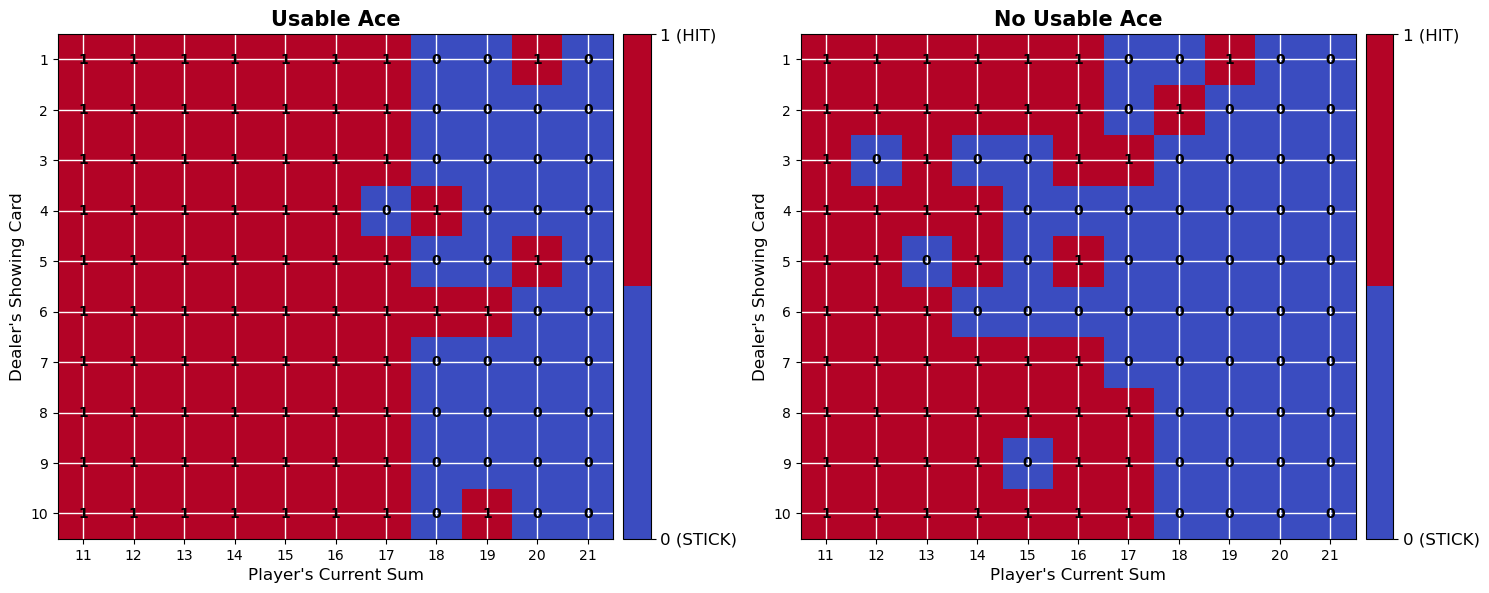

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('coolwarm', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum', fontsize=12)
        ax.set_ylabel('Dealer\'s Showing Card', fontsize=12)
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.tick_params(labelsize=12)
        for i in range(len(y_range)):
            for j in range(len(x_range)):
                ax.text(x_range[j], y_range[i], f'{int(Z[i, j])}', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=15, fontweight='bold')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=15, fontweight='bold')
    get_figure(False, ax)
    plt.tight_layout()
    plt.show()

plot_policy(policy)
